# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [3]:
import math

import gym
import matplotlib.pyplot as plt
import numpy as np
import progressbar as pb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from apex import amp

import pong_utils
from parallelEnv import parallelEnv
%matplotlib inline

In [20]:
a = torch.rand(1, 4)
for v in a:
    print(v)

tensor([0.0900, 0.6887, 0.1091, 0.3821])


In [15]:
m = nn.Conv2d(16, 1, 3, stride=2)
input = torch.randn(20, 16, 50, 100)
output = m(input)
print(output.shape)

torch.Size([20, 1, 24, 49])


In [16]:
# check which device is being used.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device)

using device:  cuda:0


In [17]:
env = gym.make('PongDeterministic-v4')
print("List of available actions: ", env.unwrapped.get_action_meanings())

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel

(210, 160, 3)


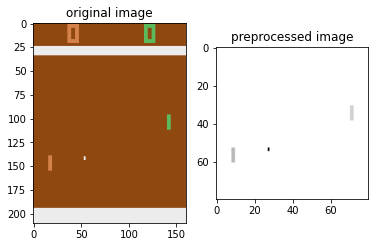

In [18]:
# show what a preprocessed image looks like
env.reset()
env.step(0)

for _ in range(20):
    frame, _, _, _ = env.step(1)

print(frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

bkg_color=np.array([144, 72, 17])
frame2 = np.mean(frame[34:-16:2, ::2] - bkg_color, axis=-1) / 255.

# 80 x 80 black and white image
plt.imshow(frame2, cmap='Greys')
plt.show()


# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [28]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()

        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        input_channel = 2
        output_channel = 16
        kernel_size = 6
        stride = 2
        
        input_size = 80
        output_size = math.ceil((input_size - kernel_size) / stride) + 1
        self.size = output_channel * output_size * output_size
        
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride)

        self.fc = nn.Linear(self.size, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, self.size)
        return self.sig(self.fc(x))

policy = Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
# policy, optimizer = amp.initialize(policy, optimizer, opt_level="O1")

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [7]:
pong_utils.play(env, policy, time=100)
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [9]:
envs = parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

# Function Definitions

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [10]:
# def surrogate(policy, old_probs, states, actions, rewards,
#               discount = 0.995, beta=0.01):

#     actions = torch.tensor(actions, dtype=torch.int8, device=device)


#     # convert states to policy (or probability)
#     new_probs = pong_utils.states_to_prob(policy, states)
#     new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

#     tensor_old_probs = torch.tensor(old_probs)

#     # include a regularization term
#     # this steers new_policy towards 0.5
#     # which prevents policy to become exactly 0 or 1
#     # this helps with exploration
#     # add in 1.e-10 to avoid log(0) which gives nan
#     entropy = -(new_probs*torch.log(tensor_old_probs+1.e-10)+ \
#         (1.0-new_probs)*torch.log(1.0-tensor_old_probs+1.e-10))

#     return torch.mean(beta*entropy)


# Lsur= surrogate(policy, prob, state, action, reward)

# print(Lsur)

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [29]:
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000
# episode = 800

widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=6)

discount_rate = .9
beta = .01
tmax = 100

# keep track of progress
mean_rewards = []

for i in range(episode):
    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)

    total_rewards = np.sum(rewards, axis=0)

    L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)

    optimizer.zero_grad()
    L.backward()
#     with amp.scale_loss(L, optimizer) as scaled_loss:
#         scaled_loss.backward()
    optimizer.step()
    del L

    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995

    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))

    # display some progress every 20 iterations
    if (i + 1) % 20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(i + 1, np.mean(total_rewards)))
        print(total_rewards)

    # update progress widget bar
    timer.update(i + 1)

timer.finish()

Episode: 20, score: -4.166667
[-4. -5. -5. -4. -5. -2.]


Episode: 40, score: -2.333333
[-4.  0. -2. -3. -5.  0.]


Episode: 60, score: -3.333333
[-2. -5. -3. -5. -1. -4.]


Episode: 80, score: -3.666667
[-4. -3. -4. -4. -3. -4.]


Episode: 100, score: -3.166667
[-2. -3. -4. -4. -4. -2.]


Episode: 120, score: -3.666667
[-2. -3. -5. -3. -4. -5.]


Episode: 140, score: -3.833333
[-3. -4. -3. -5. -4. -4.]


Episode: 160, score: -2.666667
[-3. -1. -3. -3. -3. -3.]


Episode: 180, score: -3.666667
[-5. -3. -4. -4. -3. -3.]


Episode: 200, score: -3.500000
[-3. -3. -5. -4. -2. -4.]


Episode: 220, score: -3.333333
[-4. -4. -3. -3. -4. -2.]


Episode: 240, score: -3.500000
[-5. -4. -3. -4. -4. -1.]


Episode: 260, score: -3.500000
[-4. -3. -3. -3. -5. -3.]


Episode: 280, score: -3.333333
[-4. -4. -3. -2. -4. -3.]


Episode: 300, score: -3.166667
[-4. -3. -3. -4. -4. -1.]


Episode: 320, score: -3.833333
[-4. -4. -3. -4. -4. -4.]


Episode: 340, score: -3.833333
[-5. -4. -4. -3. -4. -3.]


Episode: 360, score: -3.166667
[-1. -4. -3. -3. -4. -4.]


Episode: 380, score: -3.500000
[-3. -4. -4. -4. -2. -4.]


Episode: 400, score: -3.333333
[-4. -3. -5. -4.  0. -4.]


Episode: 420, score: -3.333333
[-4. -2. -5. -3. -3. -3.]


Episode: 440, score: -3.666667
[-4. -4. -3. -4. -3. -4.]


Episode: 460, score: -4.000000
[-3. -4. -4. -4. -4. -5.]


Episode: 480, score: -3.000000
[-2. -2. -3. -4. -4. -3.]


Episode: 500, score: -3.333333
[-4. -4. -4. -4. -3. -1.]


Episode: 520, score: -2.500000
[-3. -2. -4. -1. -2. -3.]


Episode: 540, score: -4.000000
[-3. -5. -4. -4. -4. -4.]


Episode: 560, score: -3.500000
[-3. -4. -4. -4. -3. -3.]


Episode: 580, score: -3.333333
[-2. -4. -4. -2. -4. -4.]


Episode: 600, score: -3.833333
[-4. -4. -4. -3. -4. -4.]


Episode: 620, score: -3.500000
[-5. -3. -1. -4. -3. -5.]


Episode: 640, score: -3.833333
[-4. -4. -5. -3. -3. -4.]


Episode: 660, score: -3.333333
[-3. -3. -2. -4. -5. -3.]


Episode: 680, score: -3.000000
[-4. -2. -2. -2. -3. -5.]


Episode: 700, score: -3.000000
[-3. -3. -3. -4. -1. -4.]


Episode: 720, score: -3.333333
[-3. -3. -3. -4. -3. -4.]


Episode: 740, score: -3.500000
[-5. -3. -3. -3. -4. -3.]


Episode: 760, score: -4.000000
[-4. -4. -4. -3. -5. -4.]


Episode: 780, score: -3.000000
[-3.  0. -5. -4. -3. -3.]


Episode: 800, score: -3.333333
[-3. -4. -3. -4. -3. -3.]


Episode: 820, score: -3.333333
[-3. -4. -3. -2. -5. -3.]


Episode: 840, score: -3.166667
[-3. -3. -3. -4. -3. -3.]


Episode: 860, score: -3.000000
[-1. -4. -2. -4. -4. -3.]


Episode: 880, score: -2.666667
[-5. -3. -3. -2. -3.  0.]


Episode: 900, score: -3.666667
[-3. -4. -4. -4. -3. -4.]


Episode: 920, score: -2.833333
[-3. -3. -4. -3. -3. -1.]


Episode: 940, score: -4.000000
[-4. -4. -4. -4. -3. -5.]


Episode: 960, score: -3.333333
[-3. -4. -5.  0. -5. -3.]


Episode: 980, score: -3.000000
[-2. -3. -2. -3. -4. -4.]


Episode: 1000, score: -3.833333
[-4. -4. -4. -4. -4. -3.]


In [ ]:
# play game after training!
pong_utils.play(env, policy, time=2000)

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
#torch.save(policy, 'REINFORCE-3.policy')

# load your policy if needed
policy = torch.load('REINFORCE-3.policy').cuda()

# try and test out the solution!
# policy = torch.load('PPO_solution.policy', map_location=torch.device('cpu') )